In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp1 import *

In [3]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [19]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

paths = []

for exponent in range(7):
    pow2 = 2**exponent
    paths.append((
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_train_simple_p{pow2}.txt'),
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_test_simple_p{pow2}.txt')
    ))

paths.append((
    os.path.join('data', 'simple_split', f'tasks_train_simple.txt'),
    os.path.join('data', 'simple_split', f'tasks_test_simple.txt')
))

scandataloader = SCANDataLoader()

In [20]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [25]:
def train_loss_over_epochs(path):

    
    train_data = scandataloader.load_file_path(path)

    dataset = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN
    )

    # split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN + 1,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    epochs = 25
    train_losses = []
    val_losses = []

    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            # Split target into input and output
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input)

            # Reshape output and target
            output = output.view(-1, output.shape[-1])  # (batch*seq_len, vocab_size)
            tgt_output = tgt_output.reshape(-1)        # (batch*seq_len)

            # Calculate loss
            train_loss = criterion(output, tgt_output)

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_train_loss += train_loss.item()

        avg_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_loss)  

        model.eval()
        total_val_loss = 0
        for batch in val_dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            # Split target into input and output
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input)

            # Reshape output and target
            output = output.view(-1, output.shape[-1])  # (batch*seq_len, vocab_size)
            tgt_output = tgt_output.reshape(-1)        # (batch*seq_len)

            # Calculate loss
            val_loss = criterion(output, tgt_output)

            # Backpropagation
            optimizer.zero_grad()
            val_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_val_loss += val_loss.item()

        avg_loss = total_val_loss / len(val_dataloader)
        train_losses.append(avg_loss)  

    X = list(range(1, epochs + 1))

    plt.figure(figsize=(8, 6))  # Set figure size
    plt.plot(X, train_losses, marker='o', label='Training Loss')  # Plot losses
    plt.plot(X, val_losses, marker='o', label='Validation Loss', linestyle='--')
    plt.title(f"Learning curve for the data in {os.path.basename(path)} ('Teacher-forcing')")  # Set the title
    plt.xticks(X)
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.grid(True)  # Add gridlines for better readability
    plt.legend()  # Add legend
    plt.savefig(f"plots//learning curve {os.path.basename(path)} ('Teacher-forcing')")
    plt.show()  # Display the plot


100%|██████████| 25/25 [02:34<00:00,  6.17s/it]


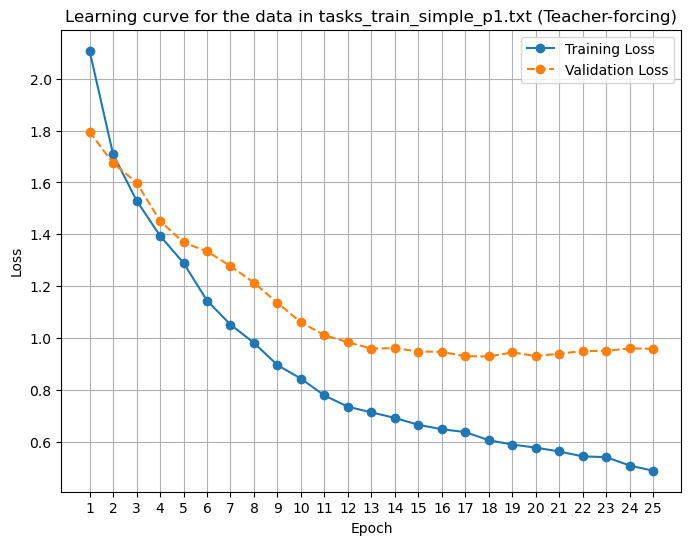

100%|██████████| 25/25 [02:51<00:00,  6.85s/it]


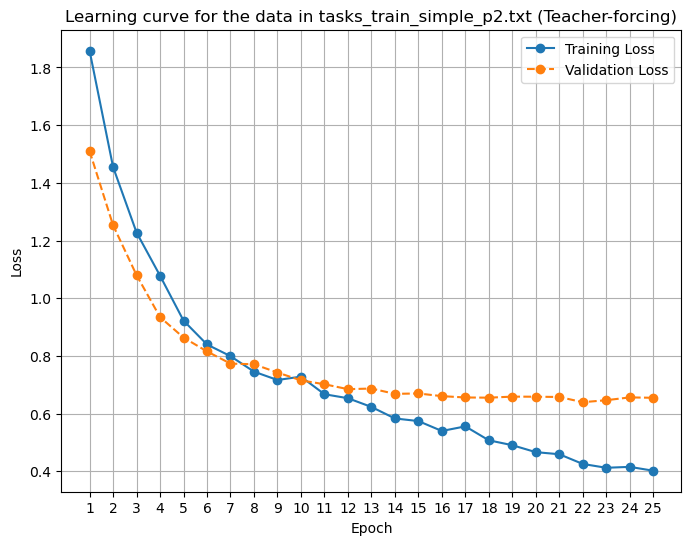

  0%|          | 0/25 [00:00<?, ?it/s]Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "c:\Users\magya\anaconda3\Lib\multiprocessing\queues.py", line 239, in _feed
    reader_close()
  File "c:\Users\magya\anaconda3\Lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "c:\Users\magya\anaconda3\Lib\multiprocessing\connection.py", line 276, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\magya\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\magya\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\magya\anaconda3\Lib\multiprocessing\queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
100%|██████████| 25/25 [03:13<00:00

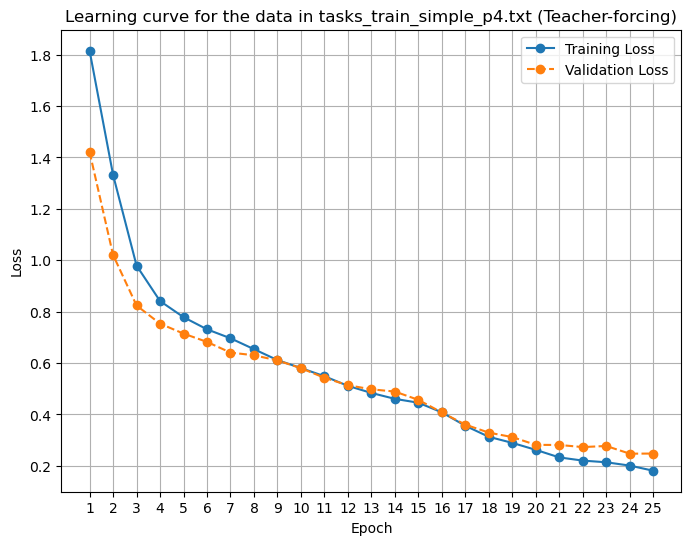

100%|██████████| 25/25 [03:26<00:00,  8.25s/it]


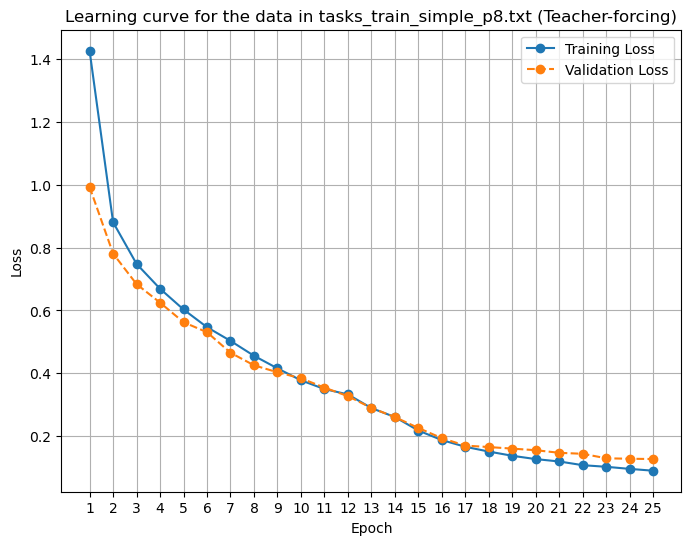

100%|██████████| 25/25 [04:01<00:00,  9.64s/it]


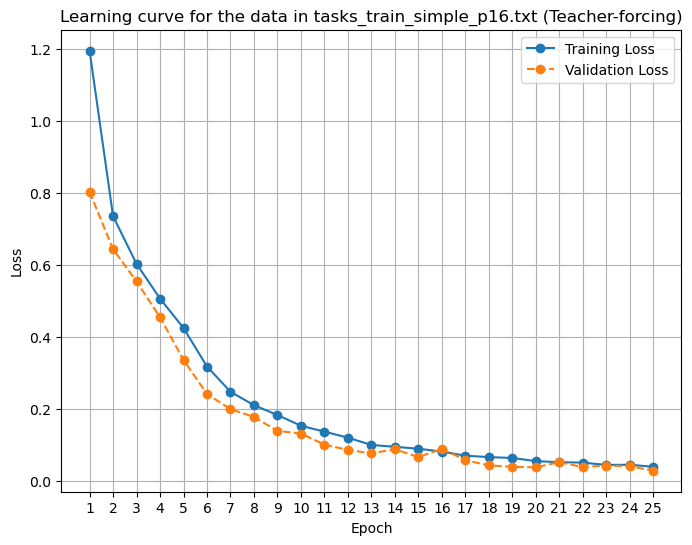

100%|██████████| 25/25 [05:49<00:00, 13.98s/it]


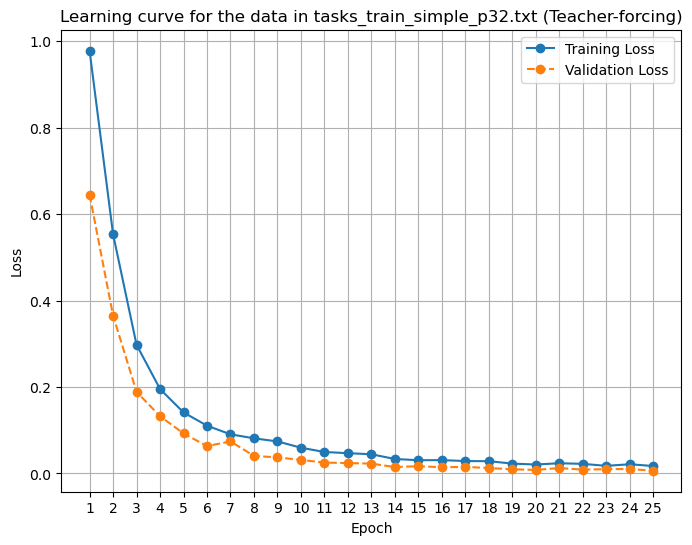

100%|██████████| 25/25 [09:23<00:00, 22.55s/it]


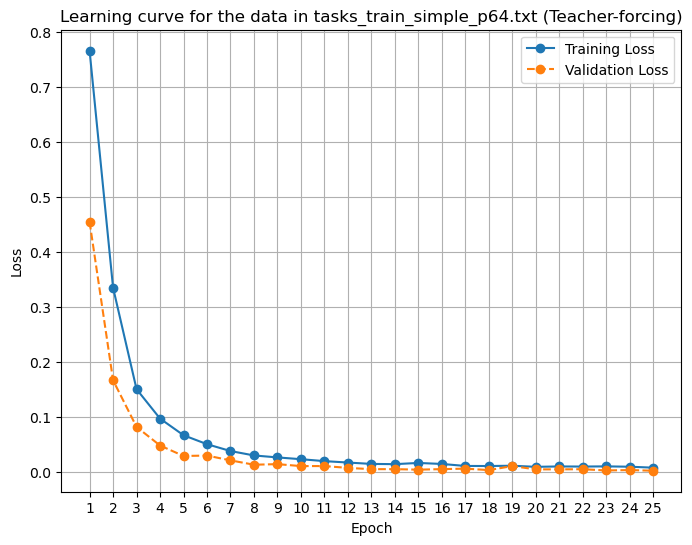

100%|██████████| 25/25 [24:35<00:00, 59.01s/it]


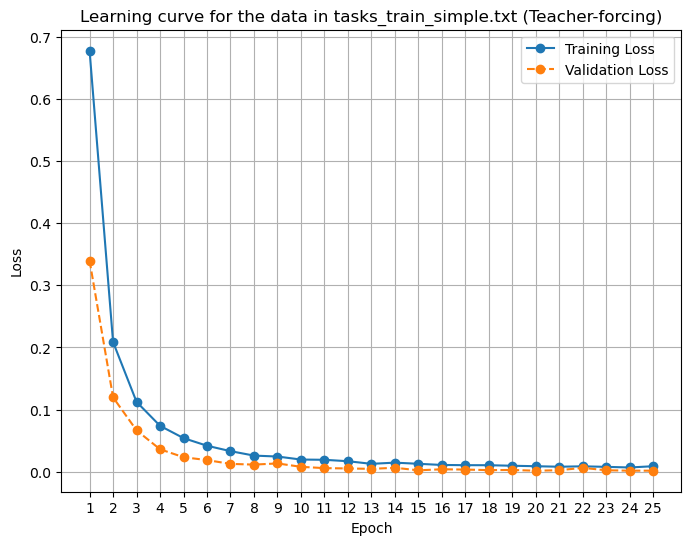

In [ ]:
for train_path, _ in paths:
    train_loss_over_epochs(train_path)

In [7]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = torch.argmax(output, -1)

            for i in range(output.size(0)):
                tgt_tokens = tgt_output[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

In [8]:
def eval_loop_autoregressive(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

Evaluation using teacher forcing

  5%|▌         | 1/20 [00:12<03:57, 12.49s/it]

Epoch 1, Loss: 2.0226


 10%|█         | 2/20 [00:24<03:37, 12.09s/it]

Epoch 2, Loss: 1.5803


 15%|█▌        | 3/20 [00:36<03:23, 11.97s/it]

Epoch 3, Loss: 1.4143


 20%|██        | 4/20 [00:47<03:10, 11.91s/it]

Epoch 4, Loss: 1.2138


 25%|██▌       | 5/20 [00:59<02:58, 11.89s/it]

Epoch 5, Loss: 1.1052


 30%|███       | 6/20 [01:11<02:46, 11.90s/it]

Epoch 6, Loss: 0.9422


 35%|███▌      | 7/20 [01:23<02:34, 11.89s/it]

Epoch 7, Loss: 0.8314


 40%|████      | 8/20 [01:35<02:22, 11.85s/it]

Epoch 8, Loss: 0.7708


 45%|████▌     | 9/20 [01:47<02:10, 11.89s/it]

Epoch 9, Loss: 0.7273


 50%|█████     | 10/20 [01:59<01:58, 11.88s/it]

Epoch 10, Loss: 0.7251


 55%|█████▌    | 11/20 [02:11<01:46, 11.88s/it]

Epoch 11, Loss: 0.6637


 60%|██████    | 12/20 [02:22<01:34, 11.86s/it]

Epoch 12, Loss: 0.6459


 65%|██████▌   | 13/20 [02:34<01:23, 11.88s/it]

Epoch 13, Loss: 0.6470


 70%|███████   | 14/20 [02:46<01:11, 11.88s/it]

Epoch 14, Loss: 0.6195


 75%|███████▌  | 15/20 [02:58<00:59, 11.98s/it]

Epoch 15, Loss: 0.6041


 80%|████████  | 16/20 [03:10<00:47, 11.93s/it]

Epoch 16, Loss: 0.5893


 85%|████████▌ | 17/20 [03:22<00:35, 11.89s/it]

Epoch 17, Loss: 0.5438


 90%|█████████ | 18/20 [03:34<00:23, 11.88s/it]

Epoch 18, Loss: 0.5545


 95%|█████████▌| 19/20 [03:46<00:11, 11.86s/it]

Epoch 19, Loss: 0.5448


100%|██████████| 20/20 [03:58<00:00, 11.90s/it]

Epoch 20, Loss: 0.4841


Token-level accuracy: 0.7481337873832563, Sequence-level accuracy: 0.06347519443505145


  4%|▍         | 1/25 [00:12<04:48, 12.03s/it]

Epoch 1, Loss: 1.8346


  8%|▊         | 2/25 [00:24<04:36, 12.00s/it]

Epoch 2, Loss: 1.3929


 12%|█▏        | 3/25 [00:36<04:24, 12.04s/it]

Epoch 3, Loss: 1.1437


 16%|█▌        | 4/25 [00:48<04:12, 12.03s/it]

Epoch 4, Loss: 0.9508


 20%|██        | 5/25 [01:00<04:01, 12.07s/it]

Epoch 5, Loss: 0.8570


 24%|██▍       | 6/25 [01:12<03:49, 12.06s/it]

Epoch 6, Loss: 0.7965


 28%|██▊       | 7/25 [01:24<03:36, 12.05s/it]

Epoch 7, Loss: 0.7585


 32%|███▏      | 8/25 [01:36<03:24, 12.04s/it]

Epoch 8, Loss: 0.7266


 36%|███▌      | 9/25 [01:48<03:12, 12.02s/it]

Epoch 9, Loss: 0.6886


 40%|████      | 10/25 [02:00<03:00, 12.02s/it]

Epoch 10, Loss: 0.6572


 44%|████▍     | 11/25 [02:12<02:48, 12.01s/it]

Epoch 11, Loss: 0.6258


 48%|████▊     | 12/25 [02:24<02:36, 12.05s/it]

Epoch 12, Loss: 0.5835


 52%|█████▏    | 13/25 [02:36<02:24, 12.03s/it]

Epoch 13, Loss: 0.5593


 56%|█████▌    | 14/25 [02:48<02:12, 12.02s/it]

Epoch 14, Loss: 0.5303


 60%|██████    | 15/25 [03:00<02:00, 12.02s/it]

Epoch 15, Loss: 0.5101


 64%|██████▍   | 16/25 [03:12<01:48, 12.01s/it]

Epoch 16, Loss: 0.4894


 68%|██████▊   | 17/25 [03:24<01:36, 12.03s/it]

Epoch 17, Loss: 0.4667


 72%|███████▏  | 18/25 [03:36<01:24, 12.03s/it]

Epoch 18, Loss: 0.4528


 76%|███████▌  | 19/25 [03:48<01:12, 12.02s/it]

Epoch 19, Loss: 0.4323


 80%|████████  | 20/25 [04:00<01:00, 12.01s/it]

Epoch 20, Loss: 0.4073


 84%|████████▍ | 21/25 [04:12<00:48, 12.02s/it]

Epoch 21, Loss: 0.3874


 88%|████████▊ | 22/25 [04:24<00:36, 12.01s/it]

Epoch 22, Loss: 0.3621


 92%|█████████▏| 23/25 [04:36<00:24, 12.01s/it]

Epoch 23, Loss: 0.3348


 96%|█████████▌| 24/25 [04:48<00:12, 12.02s/it]

Epoch 24, Loss: 0.3133


100%|██████████| 25/25 [05:00<00:00, 12.03s/it]

Epoch 25, Loss: 0.2932


Token-level accuracy: 0.8187782212649252, Sequence-level accuracy: 0.08783915674409526


  4%|▍         | 1/25 [00:13<05:16, 13.19s/it]

Epoch 1, Loss: 1.6455


  8%|▊         | 2/25 [00:26<05:00, 13.07s/it]

Epoch 2, Loss: 1.0180


 12%|█▏        | 3/25 [00:39<04:46, 13.02s/it]

Epoch 3, Loss: 0.8322


 16%|█▌        | 4/25 [00:52<04:32, 12.96s/it]

Epoch 4, Loss: 0.7587


 20%|██        | 5/25 [01:04<04:19, 12.96s/it]

Epoch 5, Loss: 0.7057


 24%|██▍       | 6/25 [01:18<04:06, 12.99s/it]

Epoch 6, Loss: 0.6545


 28%|██▊       | 7/25 [01:31<03:54, 13.05s/it]

Epoch 7, Loss: 0.6182


 32%|███▏      | 8/25 [01:44<03:41, 13.05s/it]

Epoch 8, Loss: 0.5960


 36%|███▌      | 9/25 [01:57<03:27, 12.99s/it]

Epoch 9, Loss: 0.5393


 40%|████      | 10/25 [02:10<03:15, 13.01s/it]

Epoch 10, Loss: 0.5207


 44%|████▍     | 11/25 [02:22<03:01, 12.94s/it]

Epoch 11, Loss: 0.5042


 48%|████▊     | 12/25 [02:35<02:47, 12.88s/it]

Epoch 12, Loss: 0.4509


 52%|█████▏    | 13/25 [02:48<02:35, 12.93s/it]

Epoch 13, Loss: 0.4225


 56%|█████▌    | 14/25 [03:01<02:22, 12.93s/it]

Epoch 14, Loss: 0.4022


 60%|██████    | 15/25 [03:14<02:09, 12.99s/it]

Epoch 15, Loss: 0.3393


 64%|██████▍   | 16/25 [03:27<01:57, 13.01s/it]

Epoch 16, Loss: 0.2927


 68%|██████▊   | 17/25 [03:40<01:44, 13.01s/it]

Epoch 17, Loss: 0.2773


 72%|███████▏  | 18/25 [03:54<01:31, 13.07s/it]

Epoch 18, Loss: 0.2519


 76%|███████▌  | 19/25 [04:07<01:18, 13.09s/it]

Epoch 19, Loss: 0.2270


 80%|████████  | 20/25 [04:20<01:05, 13.07s/it]

Epoch 20, Loss: 0.2076


 84%|████████▍ | 21/25 [04:33<00:52, 13.01s/it]

Epoch 21, Loss: 0.1917


 88%|████████▊ | 22/25 [04:45<00:38, 12.96s/it]

Epoch 22, Loss: 0.1742


 92%|█████████▏| 23/25 [04:58<00:25, 12.97s/it]

Epoch 23, Loss: 0.1598


 96%|█████████▌| 24/25 [05:11<00:12, 12.92s/it]

Epoch 24, Loss: 0.1548


100%|██████████| 25/25 [05:25<00:00, 13.01s/it]

Epoch 25, Loss: 0.1453


Token-level accuracy: 0.9347952210723057, Sequence-level accuracy: 0.3604662747833018


  4%|▍         | 1/25 [00:13<05:28, 13.69s/it]

Epoch 1, Loss: 1.3127


  8%|▊         | 2/25 [00:27<05:13, 13.65s/it]

Epoch 2, Loss: 0.7919


 12%|█▏        | 3/25 [00:40<04:59, 13.61s/it]

Epoch 3, Loss: 0.6791


 16%|█▌        | 4/25 [00:54<04:44, 13.54s/it]

Epoch 4, Loss: 0.5968


 20%|██        | 5/25 [01:07<04:31, 13.57s/it]

Epoch 5, Loss: 0.5207


 24%|██▍       | 6/25 [01:21<04:17, 13.55s/it]

Epoch 6, Loss: 0.4611


 28%|██▊       | 7/25 [01:35<04:05, 13.62s/it]

Epoch 7, Loss: 0.4144


 32%|███▏      | 8/25 [01:48<03:52, 13.65s/it]

Epoch 8, Loss: 0.3620


 36%|███▌      | 9/25 [02:02<03:37, 13.61s/it]

Epoch 9, Loss: 0.3001


 40%|████      | 10/25 [02:15<03:23, 13.57s/it]

Epoch 10, Loss: 0.2404


 44%|████▍     | 11/25 [02:29<03:10, 13.62s/it]

Epoch 11, Loss: 0.2006


 48%|████▊     | 12/25 [02:43<02:57, 13.62s/it]

Epoch 12, Loss: 0.1813


 52%|█████▏    | 13/25 [02:56<02:42, 13.58s/it]

Epoch 13, Loss: 0.1555


 56%|█████▌    | 14/25 [03:10<02:29, 13.56s/it]

Epoch 14, Loss: 0.1398


 60%|██████    | 15/25 [03:23<02:15, 13.57s/it]

Epoch 15, Loss: 0.1208


 64%|██████▍   | 16/25 [03:37<02:02, 13.59s/it]

Epoch 16, Loss: 0.1128


 68%|██████▊   | 17/25 [03:51<01:48, 13.57s/it]

Epoch 17, Loss: 0.1006


 72%|███████▏  | 18/25 [04:04<01:35, 13.58s/it]

Epoch 18, Loss: 0.0930


 76%|███████▌  | 19/25 [04:18<01:22, 13.67s/it]

Epoch 19, Loss: 0.0883


 80%|████████  | 20/25 [04:31<01:08, 13.61s/it]

Epoch 20, Loss: 0.0887


 84%|████████▍ | 21/25 [04:45<00:54, 13.61s/it]

Epoch 21, Loss: 0.0705


 88%|████████▊ | 22/25 [04:59<00:40, 13.59s/it]

Epoch 22, Loss: 0.0676


 92%|█████████▏| 23/25 [05:12<00:27, 13.52s/it]

Epoch 23, Loss: 0.0691


 96%|█████████▌| 24/25 [05:25<00:13, 13.50s/it]

Epoch 24, Loss: 0.0625


100%|██████████| 25/25 [05:39<00:00, 13.58s/it]

Epoch 25, Loss: 0.0554


Token-level accuracy: 0.9807152646348626, Sequence-level accuracy: 0.769570641438819


  4%|▍         | 1/25 [00:14<05:56, 14.85s/it]

Epoch 1, Loss: 1.0687


  8%|▊         | 2/25 [00:29<05:41, 14.86s/it]

Epoch 2, Loss: 0.6669


 12%|█▏        | 3/25 [00:44<05:26, 14.83s/it]

Epoch 3, Loss: 0.5226


 16%|█▌        | 4/25 [00:59<05:10, 14.81s/it]

Epoch 4, Loss: 0.4272


 20%|██        | 5/25 [01:14<04:56, 14.81s/it]

Epoch 5, Loss: 0.3446


 24%|██▍       | 6/25 [01:28<04:40, 14.77s/it]

Epoch 6, Loss: 0.2369


 28%|██▊       | 7/25 [01:43<04:25, 14.76s/it]

Epoch 7, Loss: 0.1779


 32%|███▏      | 8/25 [01:58<04:11, 14.77s/it]

Epoch 8, Loss: 0.1407


 36%|███▌      | 9/25 [02:13<03:56, 14.75s/it]

Epoch 9, Loss: 0.1124


 40%|████      | 10/25 [02:27<03:41, 14.75s/it]

Epoch 10, Loss: 0.0943


 44%|████▍     | 11/25 [02:42<03:25, 14.70s/it]

Epoch 11, Loss: 0.0807


 48%|████▊     | 12/25 [02:57<03:12, 14.79s/it]

Epoch 12, Loss: 0.0732


 52%|█████▏    | 13/25 [03:12<02:57, 14.78s/it]

Epoch 13, Loss: 0.0653


 56%|█████▌    | 14/25 [03:26<02:42, 14.74s/it]

Epoch 14, Loss: 0.0559


 60%|██████    | 15/25 [03:41<02:27, 14.80s/it]

Epoch 15, Loss: 0.0486


 64%|██████▍   | 16/25 [03:56<02:13, 14.81s/it]

Epoch 16, Loss: 0.0493


 68%|██████▊   | 17/25 [04:11<01:58, 14.78s/it]

Epoch 17, Loss: 0.0407


 72%|███████▏  | 18/25 [04:25<01:43, 14.75s/it]

Epoch 18, Loss: 0.0369


 76%|███████▌  | 19/25 [04:40<01:28, 14.72s/it]

Epoch 19, Loss: 0.0338


 80%|████████  | 20/25 [04:55<01:13, 14.70s/it]

Epoch 20, Loss: 0.0310


 84%|████████▍ | 21/25 [05:10<00:59, 14.81s/it]

Epoch 21, Loss: 0.0273


 88%|████████▊ | 22/25 [05:24<00:44, 14.75s/it]

Epoch 22, Loss: 0.0306


 92%|█████████▏| 23/25 [05:40<00:29, 14.91s/it]

Epoch 23, Loss: 0.0277


 96%|█████████▌| 24/25 [05:54<00:14, 14.83s/it]

Epoch 24, Loss: 0.0241


100%|██████████| 25/25 [06:10<00:00, 14.80s/it]

Epoch 25, Loss: 0.0234


Token-level accuracy: 0.9969392338544586, Sequence-level accuracy: 0.9603757472245944


  7%|▋         | 1/15 [00:17<04:11, 17.97s/it]

Epoch 1, Loss: 0.8713


 13%|█▎        | 2/15 [00:35<03:49, 17.62s/it]

Epoch 2, Loss: 0.5080


 20%|██        | 3/15 [00:52<03:30, 17.50s/it]

Epoch 3, Loss: 0.3396


 27%|██▋       | 4/15 [01:09<03:11, 17.38s/it]

Epoch 4, Loss: 0.1832


 33%|███▎      | 5/15 [01:27<02:53, 17.39s/it]

Epoch 5, Loss: 0.1188


 40%|████      | 6/15 [01:44<02:35, 17.33s/it]

Epoch 6, Loss: 0.0868


 47%|████▋     | 7/15 [02:01<02:18, 17.34s/it]

Epoch 7, Loss: 0.0626


 53%|█████▎    | 8/15 [02:19<02:01, 17.29s/it]

Epoch 8, Loss: 0.0493


 60%|██████    | 9/15 [02:36<01:43, 17.31s/it]

Epoch 9, Loss: 0.0391


 67%|██████▋   | 10/15 [02:53<01:26, 17.38s/it]

Epoch 10, Loss: 0.0329


 73%|███████▎  | 11/15 [03:11<01:09, 17.32s/it]

Epoch 11, Loss: 0.0275


 80%|████████  | 12/15 [03:28<00:51, 17.25s/it]

Epoch 12, Loss: 0.0226


 87%|████████▋ | 13/15 [03:45<00:34, 17.28s/it]

Epoch 13, Loss: 0.0231


 93%|█████████▎| 14/15 [04:02<00:17, 17.23s/it]

Epoch 14, Loss: 0.0203


100%|██████████| 15/15 [04:19<00:00, 17.33s/it]

Epoch 15, Loss: 0.0163


Token-level accuracy: 0.9988962634839811, Sequence-level accuracy: 0.9845980730009143


 10%|█         | 1/10 [00:22<03:20, 22.23s/it]

Epoch 1, Loss: 0.6507


 20%|██        | 2/10 [00:44<02:57, 22.22s/it]

Epoch 2, Loss: 0.1769


 30%|███       | 3/10 [01:07<02:37, 22.49s/it]

Epoch 3, Loss: 0.0828


 40%|████      | 4/10 [01:29<02:14, 22.48s/it]

Epoch 4, Loss: 0.0519


 50%|█████     | 5/10 [01:52<01:52, 22.54s/it]

Epoch 5, Loss: 0.0360


 60%|██████    | 6/10 [02:14<01:30, 22.55s/it]

Epoch 6, Loss: 0.0284


 70%|███████   | 7/10 [02:37<01:08, 22.69s/it]

Epoch 7, Loss: 0.0236


 80%|████████  | 8/10 [03:01<00:45, 22.88s/it]

Epoch 8, Loss: 0.0176


 90%|█████████ | 9/10 [03:24<00:23, 23.11s/it]

Epoch 9, Loss: 0.0144


100%|██████████| 10/10 [03:47<00:00, 22.77s/it]

Epoch 10, Loss: 0.0136


Token-level accuracy: 0.9992054663912283, Sequence-level accuracy: 0.9889744952178533


 10%|█         | 1/10 [00:25<03:48, 25.37s/it]

Epoch 1, Loss: 0.6208


 20%|██        | 2/10 [00:51<03:25, 25.70s/it]

Epoch 2, Loss: 0.1426


 30%|███       | 3/10 [01:17<03:02, 26.05s/it]

Epoch 3, Loss: 0.0691


 40%|████      | 4/10 [01:44<02:37, 26.23s/it]

Epoch 4, Loss: 0.0442


 50%|█████     | 5/10 [02:11<02:12, 26.41s/it]

Epoch 5, Loss: 0.0307


 60%|██████    | 6/10 [02:37<01:45, 26.28s/it]

Epoch 6, Loss: 0.0230


 70%|███████   | 7/10 [03:03<01:19, 26.34s/it]

Epoch 7, Loss: 0.0182


 80%|████████  | 8/10 [03:29<00:52, 26.31s/it]

Epoch 8, Loss: 0.0147


 90%|█████████ | 9/10 [03:56<00:26, 26.31s/it]

Epoch 9, Loss: 0.0117


100%|██████████| 10/10 [04:22<00:00, 26.23s/it]

Epoch 10, Loss: 0.0111


Token-level accuracy: 0.9999161355249916, Sequence-level accuracy: 0.998804399808704


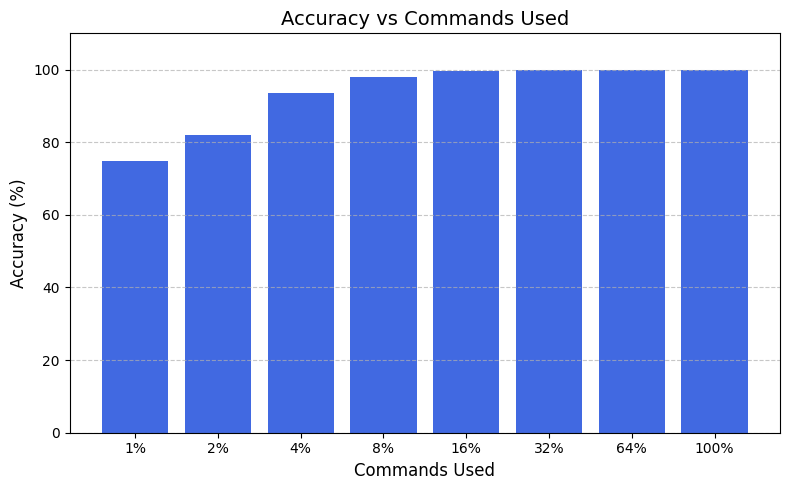

In [20]:
N = 8
#epochs = 20
epochs = [20, 25, 25, 25, 25, 15, 10, 10]
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    train_data = scandataloader.load_file_path(train_path)
    test_data = scandataloader.load_file_path(test_path)

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs[i])

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
train_path, test_path = paths[1]
epochs=30

train_data = scandataloader.load_file_path(train_path)
test_data = scandataloader.load_file_path(test_path)

dataset_train = SCANDataset(
    data=train_data,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    max_len=MAX_LEN,
)

dataset_test = SCANDataset(
    data=test_data,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    max_len=MAX_LEN,
)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_pad_idx=src_vocab['<PAD>'],
    tgt_pad_idx=tgt_vocab['<PAD>'],
    emb_dim=EMB_DIM,
    num_layers=N_LAYERS,
    num_heads=N_HEADS,
    forward_dim=FORWARD_DIM,
    dropout=DROPOUT,
    max_len=MAX_LEN,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

train_loop(model, optimizer, criterion, dataloader_train, epochs)

token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

  3%|▎         | 1/30 [00:12<06:13, 12.87s/it]

Epoch 1, Loss: 1.8485


  7%|▋         | 2/30 [00:25<05:51, 12.55s/it]

Epoch 2, Loss: 1.4050


 10%|█         | 3/30 [00:37<05:32, 12.32s/it]

Epoch 3, Loss: 1.1529


 13%|█▎        | 4/30 [00:49<05:21, 12.35s/it]

Epoch 4, Loss: 0.9497


 17%|█▋        | 5/30 [01:01<05:05, 12.23s/it]

Epoch 5, Loss: 0.8473


 20%|██        | 6/30 [01:13<04:51, 12.16s/it]

Epoch 6, Loss: 0.7857


 23%|██▎       | 7/30 [01:25<04:39, 12.17s/it]

Epoch 7, Loss: 0.7430


 27%|██▋       | 8/30 [01:38<04:27, 12.16s/it]

Epoch 8, Loss: 0.7022


 30%|███       | 9/30 [01:50<04:15, 12.15s/it]

Epoch 9, Loss: 0.6642


 33%|███▎      | 10/30 [02:02<04:02, 12.14s/it]

Epoch 10, Loss: 0.6344


 37%|███▋      | 11/30 [02:14<03:49, 12.09s/it]

Epoch 11, Loss: 0.6001


 40%|████      | 12/30 [02:26<03:37, 12.07s/it]

Epoch 12, Loss: 0.5759


 43%|████▎     | 13/30 [02:38<03:25, 12.06s/it]

Epoch 13, Loss: 0.5452


 47%|████▋     | 14/30 [02:50<03:12, 12.04s/it]

Epoch 14, Loss: 0.5288


 50%|█████     | 15/30 [03:02<03:00, 12.05s/it]

Epoch 15, Loss: 0.5035


 53%|█████▎    | 16/30 [03:14<02:48, 12.07s/it]

Epoch 16, Loss: 0.4807


 57%|█████▋    | 17/30 [03:26<02:36, 12.04s/it]

Epoch 17, Loss: 0.4689


 60%|██████    | 18/30 [03:38<02:24, 12.06s/it]

Epoch 18, Loss: 0.4421


 63%|██████▎   | 19/30 [03:50<02:12, 12.04s/it]

Epoch 19, Loss: 0.4141


 67%|██████▋   | 20/30 [04:02<02:00, 12.04s/it]

Epoch 20, Loss: 0.4034


 70%|███████   | 21/30 [04:14<01:48, 12.02s/it]

Epoch 21, Loss: 0.3796


 73%|███████▎  | 22/30 [04:27<01:37, 12.14s/it]

Epoch 22, Loss: 0.3506


 77%|███████▋  | 23/30 [04:38<01:24, 12.09s/it]

Epoch 23, Loss: 0.3334


 80%|████████  | 24/30 [04:50<01:12, 12.05s/it]

Epoch 24, Loss: 0.3178


 83%|████████▎ | 25/30 [05:03<01:00, 12.07s/it]

Epoch 25, Loss: 0.2888


 87%|████████▋ | 26/30 [05:15<00:48, 12.05s/it]

Epoch 26, Loss: 0.2673


 90%|█████████ | 27/30 [05:27<00:36, 12.06s/it]

Epoch 27, Loss: 0.2458


 93%|█████████▎| 28/30 [05:39<00:24, 12.03s/it]

Epoch 28, Loss: 0.2437


 97%|█████████▋| 29/30 [05:51<00:12, 12.02s/it]

Epoch 29, Loss: 0.2307


100%|██████████| 30/30 [06:03<00:00, 12.10s/it]

Epoch 30, Loss: 0.2212


Token-level accuracy: 0.8508351963196238, Sequence-level accuracy: 0.14327542455592426


Evaluation Autoregressive

  5%|▌         | 1/20 [00:12<04:00, 12.67s/it]

Epoch 1, Loss: 2.0503


 10%|█         | 2/20 [00:24<03:38, 12.15s/it]

Epoch 2, Loss: 1.6389


 15%|█▌        | 3/20 [00:36<03:24, 12.01s/it]

Epoch 3, Loss: 1.4285


 20%|██        | 4/20 [00:47<03:10, 11.88s/it]

Epoch 4, Loss: 1.2553


 25%|██▌       | 5/20 [01:00<02:59, 11.98s/it]

Epoch 5, Loss: 1.1235


 30%|███       | 6/20 [01:11<02:46, 11.88s/it]

Epoch 6, Loss: 0.9688


 35%|███▌      | 7/20 [01:23<02:34, 11.90s/it]

Epoch 7, Loss: 0.8806


 40%|████      | 8/20 [01:35<02:22, 11.89s/it]

Epoch 8, Loss: 0.8387


 45%|████▌     | 9/20 [01:47<02:10, 11.83s/it]

Epoch 9, Loss: 0.7639


 50%|█████     | 10/20 [01:58<01:57, 11.74s/it]

Epoch 10, Loss: 0.7255


 55%|█████▌    | 11/20 [02:10<01:45, 11.70s/it]

Epoch 11, Loss: 0.7241


 60%|██████    | 12/20 [02:22<01:34, 11.82s/it]

Epoch 12, Loss: 0.6682


 65%|██████▌   | 13/20 [02:34<01:22, 11.81s/it]

Epoch 13, Loss: 0.6514


 70%|███████   | 14/20 [02:46<01:11, 11.87s/it]

Epoch 14, Loss: 0.6258


 75%|███████▌  | 15/20 [02:57<00:58, 11.80s/it]

Epoch 15, Loss: 0.6405


 80%|████████  | 16/20 [03:09<00:47, 11.81s/it]

Epoch 16, Loss: 0.5850


 85%|████████▌ | 17/20 [03:21<00:35, 11.84s/it]

Epoch 17, Loss: 0.5551


 90%|█████████ | 18/20 [03:33<00:23, 11.82s/it]

Epoch 18, Loss: 0.5330


 95%|█████████▌| 19/20 [03:45<00:11, 11.90s/it]

Epoch 19, Loss: 0.5241


100%|██████████| 20/20 [03:57<00:00, 11.87s/it]

Epoch 20, Loss: 0.4844


Token-level accuracy: 0.5551266057520483, Sequence-level accuracy: 0.06405487657601082


  4%|▍         | 1/25 [00:13<05:16, 13.20s/it]

Epoch 1, Loss: 1.8679


  8%|▊         | 2/25 [00:25<04:48, 12.53s/it]

Epoch 2, Loss: 1.4038


 12%|█▏        | 3/25 [00:37<04:30, 12.31s/it]

Epoch 3, Loss: 1.1215


 16%|█▌        | 4/25 [00:49<04:18, 12.31s/it]

Epoch 4, Loss: 0.9497


 20%|██        | 5/25 [01:02<04:07, 12.38s/it]

Epoch 5, Loss: 0.8565


 24%|██▍       | 6/25 [01:14<03:53, 12.28s/it]

Epoch 6, Loss: 0.7995


 28%|██▊       | 7/25 [01:26<03:39, 12.21s/it]

Epoch 7, Loss: 0.7733


 32%|███▏      | 8/25 [01:38<03:26, 12.13s/it]

Epoch 8, Loss: 0.7204


 36%|███▌      | 9/25 [01:50<03:14, 12.16s/it]

Epoch 9, Loss: 0.6862


 40%|████      | 10/25 [02:02<03:01, 12.10s/it]

Epoch 10, Loss: 0.6645


 44%|████▍     | 11/25 [02:14<02:49, 12.12s/it]

Epoch 11, Loss: 0.6317


 48%|████▊     | 12/25 [02:26<02:37, 12.09s/it]

Epoch 12, Loss: 0.6030


 52%|█████▏    | 13/25 [02:38<02:24, 12.08s/it]

Epoch 13, Loss: 0.5744


 56%|█████▌    | 14/25 [02:50<02:12, 12.08s/it]

Epoch 14, Loss: 0.5544


 60%|██████    | 15/25 [03:02<02:00, 12.05s/it]

Epoch 15, Loss: 0.5174


 64%|██████▍   | 16/25 [03:14<01:48, 12.01s/it]

Epoch 16, Loss: 0.4871


 68%|██████▊   | 17/25 [03:26<01:36, 12.02s/it]

Epoch 17, Loss: 0.4751


 72%|███████▏  | 18/25 [03:38<01:24, 12.02s/it]

Epoch 18, Loss: 0.4433


 76%|███████▌  | 19/25 [03:50<01:12, 12.02s/it]

Epoch 19, Loss: 0.4198


 80%|████████  | 20/25 [04:02<00:59, 12.00s/it]

Epoch 20, Loss: 0.4114


 84%|████████▍ | 21/25 [04:14<00:47, 11.99s/it]

Epoch 21, Loss: 0.3899


 88%|████████▊ | 22/25 [04:26<00:35, 11.99s/it]

Epoch 22, Loss: 0.3672


 92%|█████████▏| 23/25 [04:38<00:23, 11.98s/it]

Epoch 23, Loss: 0.3441


 96%|█████████▌| 24/25 [04:50<00:12, 12.07s/it]

Epoch 24, Loss: 0.3229


100%|██████████| 25/25 [05:03<00:00, 12.12s/it]

Epoch 25, Loss: 0.3085


Token-level accuracy: 0.6072144356767829, Sequence-level accuracy: 0.09569588131953934


  4%|▍         | 1/25 [00:13<05:35, 13.99s/it]

Epoch 1, Loss: 1.6539


  8%|▊         | 2/25 [00:27<05:10, 13.51s/it]

Epoch 2, Loss: 1.1329


 12%|█▏        | 3/25 [00:39<04:49, 13.18s/it]

Epoch 3, Loss: 0.8636


 16%|█▌        | 4/25 [00:52<04:33, 13.02s/it]

Epoch 4, Loss: 0.7431


 20%|██        | 5/25 [01:05<04:18, 12.94s/it]

Epoch 5, Loss: 0.7003


 24%|██▍       | 6/25 [01:18<04:05, 12.91s/it]

Epoch 6, Loss: 0.6357


 28%|██▊       | 7/25 [01:31<03:51, 12.84s/it]

Epoch 7, Loss: 0.6076


 32%|███▏      | 8/25 [01:43<03:37, 12.82s/it]

Epoch 8, Loss: 0.5775


 36%|███▌      | 9/25 [01:56<03:24, 12.81s/it]

Epoch 9, Loss: 0.5260


 40%|████      | 10/25 [02:09<03:12, 12.82s/it]

Epoch 10, Loss: 0.5059


 44%|████▍     | 11/25 [02:22<02:59, 12.80s/it]

Epoch 11, Loss: 0.4734


 48%|████▊     | 12/25 [02:35<02:46, 12.84s/it]

Epoch 12, Loss: 0.4640


 52%|█████▏    | 13/25 [02:48<02:34, 12.85s/it]

Epoch 13, Loss: 0.4312


 56%|█████▌    | 14/25 [03:01<02:22, 12.96s/it]

Epoch 14, Loss: 0.3934


 60%|██████    | 15/25 [03:14<02:09, 12.93s/it]

Epoch 15, Loss: 0.3493


 64%|██████▍   | 16/25 [03:26<01:56, 12.90s/it]

Epoch 16, Loss: 0.3133


 68%|██████▊   | 17/25 [03:39<01:42, 12.86s/it]

Epoch 17, Loss: 0.2895


 72%|███████▏  | 18/25 [03:52<01:29, 12.85s/it]

Epoch 18, Loss: 0.2707


 76%|███████▌  | 19/25 [04:05<01:17, 12.84s/it]

Epoch 19, Loss: 0.2372


 80%|████████  | 20/25 [04:18<01:04, 12.82s/it]

Epoch 20, Loss: 0.2190


 84%|████████▍ | 21/25 [04:30<00:51, 12.82s/it]

Epoch 21, Loss: 0.1977


 88%|████████▊ | 22/25 [04:43<00:38, 12.83s/it]

Epoch 22, Loss: 0.1860


 92%|█████████▏| 23/25 [04:56<00:25, 12.81s/it]

Epoch 23, Loss: 0.1676


 96%|█████████▌| 24/25 [05:09<00:12, 12.83s/it]

Epoch 24, Loss: 0.1573


100%|██████████| 25/25 [05:22<00:00, 12.89s/it]

Epoch 25, Loss: 0.1335


Token-level accuracy: 0.8060358454317745, Sequence-level accuracy: 0.40001992627279065


  4%|▍         | 1/25 [00:15<06:16, 15.68s/it]

Epoch 1, Loss: 1.3354


  8%|▊         | 2/25 [00:29<05:32, 14.44s/it]

Epoch 2, Loss: 0.8307


 12%|█▏        | 3/25 [00:42<05:07, 13.97s/it]

Epoch 3, Loss: 0.7060


 16%|█▌        | 4/25 [00:56<04:49, 13.77s/it]

Epoch 4, Loss: 0.6263


 20%|██        | 5/25 [01:09<04:33, 13.68s/it]

Epoch 5, Loss: 0.5424


 24%|██▍       | 6/25 [01:23<04:19, 13.64s/it]

Epoch 6, Loss: 0.4706


 28%|██▊       | 7/25 [01:37<04:06, 13.72s/it]

Epoch 7, Loss: 0.3688


 32%|███▏      | 8/25 [01:50<03:51, 13.63s/it]

Epoch 8, Loss: 0.2879


 36%|███▌      | 9/25 [02:04<03:37, 13.59s/it]

Epoch 9, Loss: 0.2316


 40%|████      | 10/25 [02:17<03:23, 13.58s/it]

Epoch 10, Loss: 0.1920


 44%|████▍     | 11/25 [02:31<03:09, 13.54s/it]

Epoch 11, Loss: 0.1684


 48%|████▊     | 12/25 [02:44<02:56, 13.54s/it]

Epoch 12, Loss: 0.1546


 52%|█████▏    | 13/25 [02:58<02:42, 13.54s/it]

Epoch 13, Loss: 0.1498


 56%|█████▌    | 14/25 [03:11<02:29, 13.60s/it]

Epoch 14, Loss: 0.1226


 60%|██████    | 15/25 [03:25<02:15, 13.55s/it]

Epoch 15, Loss: 0.1158


 64%|██████▍   | 16/25 [03:39<02:02, 13.60s/it]

Epoch 16, Loss: 0.1102


 68%|██████▊   | 17/25 [03:52<01:48, 13.55s/it]

Epoch 17, Loss: 0.0985


 72%|███████▏  | 18/25 [04:05<01:34, 13.52s/it]

Epoch 18, Loss: 0.0901


 76%|███████▌  | 19/25 [04:19<01:21, 13.51s/it]

Epoch 19, Loss: 0.0845


 80%|████████  | 20/25 [04:32<01:07, 13.50s/it]

Epoch 20, Loss: 0.0803


 84%|████████▍ | 21/25 [04:46<00:53, 13.50s/it]

Epoch 21, Loss: 0.0773


 88%|████████▊ | 22/25 [04:59<00:40, 13.49s/it]

Epoch 22, Loss: 0.0700


 92%|█████████▏| 23/25 [05:13<00:26, 13.46s/it]

Epoch 23, Loss: 0.0657


 96%|█████████▌| 24/25 [05:26<00:13, 13.48s/it]

Epoch 24, Loss: 0.0634


100%|██████████| 25/25 [05:40<00:00, 13.62s/it]

Epoch 25, Loss: 0.0590


Token-level accuracy: 0.9476495029258848, Sequence-level accuracy: 0.7822018920885747


  4%|▍         | 1/25 [00:14<05:56, 14.87s/it]

Epoch 1, Loss: 1.0791


  8%|▊         | 2/25 [00:29<05:38, 14.70s/it]

Epoch 2, Loss: 0.6488


 12%|█▏        | 3/25 [00:45<05:38, 15.39s/it]

Epoch 3, Loss: 0.4960


 16%|█▌        | 4/25 [01:00<05:16, 15.05s/it]

Epoch 4, Loss: 0.3431


 20%|██        | 5/25 [01:14<04:57, 14.90s/it]

Epoch 5, Loss: 0.2330


 24%|██▍       | 6/25 [01:29<04:41, 14.81s/it]

Epoch 6, Loss: 0.1794


 28%|██▊       | 7/25 [01:44<04:25, 14.73s/it]

Epoch 7, Loss: 0.1315


 32%|███▏      | 8/25 [01:58<04:09, 14.66s/it]

Epoch 8, Loss: 0.1136


 36%|███▌      | 9/25 [02:13<03:53, 14.62s/it]

Epoch 9, Loss: 0.0955


 40%|████      | 10/25 [02:27<03:39, 14.61s/it]

Epoch 10, Loss: 0.0825


 44%|████▍     | 11/25 [02:42<03:24, 14.62s/it]

Epoch 11, Loss: 0.0740


 48%|████▊     | 12/25 [02:56<03:09, 14.61s/it]

Epoch 12, Loss: 0.0650


 52%|█████▏    | 13/25 [03:11<02:55, 14.61s/it]

Epoch 13, Loss: 0.0597


 56%|█████▌    | 14/25 [03:25<02:40, 14.58s/it]

Epoch 14, Loss: 0.0545


 60%|██████    | 15/25 [03:40<02:26, 14.61s/it]

Epoch 15, Loss: 0.0472


 64%|██████▍   | 16/25 [03:55<02:13, 14.81s/it]

Epoch 16, Loss: 0.0478


 68%|██████▊   | 17/25 [04:10<01:58, 14.80s/it]

Epoch 17, Loss: 0.0388


 72%|███████▏  | 18/25 [04:25<01:44, 14.93s/it]

Epoch 18, Loss: 0.0361


 76%|███████▌  | 19/25 [04:40<01:29, 14.87s/it]

Epoch 19, Loss: 0.0351


 80%|████████  | 20/25 [04:55<01:14, 14.93s/it]

Epoch 20, Loss: 0.0287


 84%|████████▍ | 21/25 [05:10<00:59, 14.80s/it]

Epoch 21, Loss: 0.0274


 88%|████████▊ | 22/25 [05:24<00:44, 14.75s/it]

Epoch 22, Loss: 0.0271


 92%|█████████▏| 23/25 [05:39<00:29, 14.71s/it]

Epoch 23, Loss: 0.0263


 96%|█████████▌| 24/25 [05:54<00:14, 14.86s/it]

Epoch 24, Loss: 0.0232


100%|██████████| 25/25 [06:09<00:00, 14.80s/it]

Epoch 25, Loss: 0.0191


Token-level accuracy: 0.9934292903395066, Sequence-level accuracy: 0.9608311984059209


  7%|▋         | 1/15 [00:19<04:36, 19.74s/it]

Epoch 1, Loss: 0.8768


 13%|█▎        | 2/15 [00:37<04:00, 18.54s/it]

Epoch 2, Loss: 0.4989


 20%|██        | 3/15 [00:54<03:35, 17.97s/it]

Epoch 3, Loss: 0.2686


 27%|██▋       | 4/15 [01:13<03:18, 18.09s/it]

Epoch 4, Loss: 0.1484


 33%|███▎      | 5/15 [01:30<02:57, 17.79s/it]

Epoch 5, Loss: 0.1059


 40%|████      | 6/15 [01:47<02:39, 17.73s/it]

Epoch 6, Loss: 0.0822


 47%|████▋     | 7/15 [02:05<02:20, 17.57s/it]

Epoch 7, Loss: 0.0627


 53%|█████▎    | 8/15 [02:22<02:02, 17.45s/it]

Epoch 8, Loss: 0.0520


 60%|██████    | 9/15 [02:39<01:44, 17.35s/it]

Epoch 9, Loss: 0.0428


 67%|██████▋   | 10/15 [02:56<01:26, 17.36s/it]

Epoch 10, Loss: 0.0355


 73%|███████▎  | 11/15 [03:13<01:09, 17.26s/it]

Epoch 11, Loss: 0.0313


 80%|████████  | 12/15 [03:31<00:51, 17.31s/it]

Epoch 12, Loss: 0.0264


 87%|████████▋ | 13/15 [03:48<00:34, 17.32s/it]

Epoch 13, Loss: 0.0223


 93%|█████████▎| 14/15 [04:06<00:17, 17.52s/it]

Epoch 14, Loss: 0.0204


100%|██████████| 15/15 [04:23<00:00, 17.60s/it]

Epoch 15, Loss: 0.0171


Token-level accuracy: 0.9962472958455357, Sequence-level accuracy: 0.9814332934805542


 10%|█         | 1/10 [00:25<03:49, 25.50s/it]

Epoch 1, Loss: 0.6391


 20%|██        | 2/10 [00:49<03:15, 24.39s/it]

Epoch 2, Loss: 0.1861


 30%|███       | 3/10 [01:13<02:51, 24.47s/it]

Epoch 3, Loss: 0.0997


 40%|████      | 4/10 [01:37<02:24, 24.13s/it]

Epoch 4, Loss: 0.0614


 50%|█████     | 5/10 [02:00<01:59, 23.91s/it]

Epoch 5, Loss: 0.0433


 60%|██████    | 6/10 [02:24<01:34, 23.75s/it]

Epoch 6, Loss: 0.0307


 70%|███████   | 7/10 [02:48<01:11, 23.77s/it]

Epoch 7, Loss: 0.0270


 80%|████████  | 8/10 [03:11<00:47, 23.66s/it]

Epoch 8, Loss: 0.0206


 90%|█████████ | 9/10 [03:35<00:23, 23.62s/it]

Epoch 9, Loss: 0.0195


100%|██████████| 10/10 [03:58<00:00, 23.90s/it]

Epoch 10, Loss: 0.0163


Token-level accuracy: 0.9931763584187846, Sequence-level accuracy: 0.9527098831030818


 10%|█         | 1/10 [00:28<04:18, 28.72s/it]

Epoch 1, Loss: 0.6097


 20%|██        | 2/10 [00:55<03:42, 27.83s/it]

Epoch 2, Loss: 0.1776


 30%|███       | 3/10 [01:23<03:13, 27.66s/it]

Epoch 3, Loss: 0.0751


 40%|████      | 4/10 [01:50<02:44, 27.39s/it]

Epoch 4, Loss: 0.0413


 50%|█████     | 5/10 [02:17<02:16, 27.29s/it]

Epoch 5, Loss: 0.0294


 60%|██████    | 6/10 [02:45<01:50, 27.55s/it]

Epoch 6, Loss: 0.0202


 70%|███████   | 7/10 [03:13<01:22, 27.62s/it]

Epoch 7, Loss: 0.0181


 80%|████████  | 8/10 [03:42<00:56, 28.03s/it]

Epoch 8, Loss: 0.0144


 90%|█████████ | 9/10 [04:09<00:27, 27.66s/it]

Epoch 9, Loss: 0.0124


100%|██████████| 10/10 [04:35<00:00, 27.56s/it]

Epoch 10, Loss: 0.0118


Token-level accuracy: 0.9994464944649446, Sequence-level accuracy: 0.9959349593495935


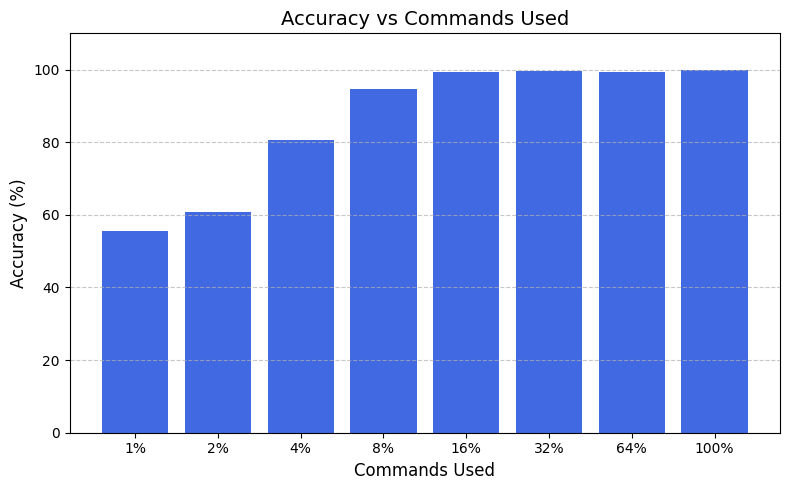

In [9]:
N = 8
epochs = [20, 25, 25, 25, 25, 15, 10, 10]
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    train_data = scandataloader.load_file_path(train_path)
    test_data = scandataloader.load_file_path(test_path)

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs[i])

    token_accuracy, seq_accuracy = eval_loop_autoregressive(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()